# Simulating DESI Spectra

The goal of this notebook is to demonstrate how to generate some simple DESI spectra using the `quickgen` utility.  For simplicity we will only generate 1D spectra and skip the more computationally intensive (yet still instructive!) step of extracting 1D spectra from simulated 2D spectra (i.e., so-called "pixel-level simulations").

For additional (albeit somewhat outdated) information and documentation about `quickgen` see  
https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=1429

The heart of `quickgen` is the `SpecSim` package, which you can read out here:  
http://specsim.readthedocs.io/en/stable

If you identify any errors or have requests for additional functionality please create a new issue on  
https://github.com/desihub/desisim/issues
or send a note to <desi-data@desi.lbl.gov>.

## Getting started.

First, import all the package dependencies.

In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table

In [2]:
import desispec.io
import desisim.io
from desisim.obs import new_exposure
from desisim.scripts import quickgen
from desispec.scripts import group_spectra

/Users/sbailey/anaconda/envs/desi/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Check and set your environment

Next, make sure we have all the right environment variables set (assuming the bash shell).  If any of these environment variables are missing please set them in your `.bashrc` file (and then restart this notebook) or create them for just this notebook session using the `%set_env` magic command, as we demonstrate below.

In [4]:
def check_env():
    for env in ('DESIMODEL', 'DESI_ROOT', 'DESI_SPECTRO_SIM', 'DESI_SPECTRO_DATA', 
            'DESI_SPECTRO_REDUX', 'SPECPROD', 'PIXPROD'):
        if env in os.environ:
            print('{} environment set to {}'.format(env, os.getenv(env)))
        else:
            print('Required environment variable {} not set!'.format(env))

In [5]:
check_env()

DESIMODEL environment set to /Users/sbailey/desi/git/desimodel/svn/trunk
DESI_ROOT environment set to /data/desi
DESI_SPECTRO_SIM environment set to /data/desi/spectro/sim
DESI_SPECTRO_DATA environment set to /data/desi/spectro/data
DESI_SPECTRO_REDUX environment set to /data/desi/spectro/redux
SPECPROD environment set to debug
PIXPROD environment set to debug


Let's reassign the `$SPECPROD` environment to something other than `dailytest` so that we don't conflict with the outputs of the standard DESI integration test.  In addition, we need to make raw data input `$DESI_SPECTO_DATA` match `$DESI_SPECTRO_SIM/$PIXPROD` where the simulated data will be written.

In [6]:
%set_env SPECPROD=example
%set_env PIXPROD=example
rawdata_dir = desisim.io.simdir()
%set_env DESI_SPECTRO_DATA=$rawdata_dir

print('Simulated raw data will be written to {}'.format(desisim.io.simdir()))
print('Pipeline will read raw data from {}'.format(desispec.io.rawdata_root()))
print('    (without knowing that it was simulated)')
print('Pipeline will write processed data to {}'.format(desispec.io.specprod_root()))

env: SPECPROD=example
env: PIXPROD=example
env: DESI_SPECTRO_DATA=/data/desi/spectro/sim/example/
Simulated raw data will be written to /data/desi/spectro/sim/example/
Pipeline will read raw data from /data/desi/spectro/sim/example/
    (without knowing that it was simulated)
Pipeline will write processed data to /data/desi/spectro/redux/example


## Specify the parameters of the simulation.

Next, let's specify the number and spectral type distribution of spectra we want to simulate, and the random seed.  Setting the seed here (which can be any number at all!) ensures that your simulations are reproducible.  Let's also explicitly set the *night* of the "observations" (the default is to use the current date) and the *expid* or exposure ID number (which would allow you to simulate more than one DESI exposure).

The *flavor* option is used to choose the correct sky-brightness model and it also determines the distribution of targets for a given flavor.  For example, *flavor='dark'* returns the right relative sampling density of ELGs, LRGs, and QSOs.  The other available (science target) options for *flavor* are 'dark', 'gray', 'grey', 'bright', 'bgs', 'mws', 'lrg', 'elg', 'qso', and 'std'.  (You can also set flavor to either 'arc' or 'flat' but that would be boring!)

In [7]:
nspec = 100
seed = 555
program = 'dark'
night = '20170615'
expid = 0

## Generating noiseless spectra. ##

The first step is to generate the `fibermap` and `simspec` files needed by `quickgen`.  The `fibermap` table contains (simulated) information about the position of each target in the DESI focal plane, while the `simspec` table holds the "truth" spectra and the intrinsic properties of each object (redshift, noiseless photometry, [OII] flux, etc.).

In detail, the *simspec* and *fibermap* data models are described at  
* http://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_SIM/PIXPROD/NIGHT/simspec-EXPID.html
* http://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_DATA/NIGHT/fibermap-EXPID.html

To generate these files we'll use `new_exposure`, a convenience function for generating random typical exposures of various types for testing.  However, note that `new_exposure` isn't intended for every possible analysis; if you want to use your own mix of objects, you just need to write your own fibermap and simspec files following that format instead of calling `new_exposure`.

Note that in our call to `new_exposure`, the `tileid` and `exptime` (exposure time) optional inputs are shown for demonstration purposes but do not need to be explicitly set.  In particular, the default exposure time is based on the value specified in the *$DESIMODEL/data/desi.yaml* parameter file.

**Note**: The simspec file format may change in the near future, so structure your code to separate generating spectra from the code for writing these particular formats.

In [8]:
sim, fibermap, meta, obsconditions = \
    new_exposure(program=program, nspec=nspec, seed=seed, night=night, 
                 expid=expid, tileid=None, exptime=None)

DEBUG:obs.py:301:get_next_tileid: 8038 tiles in program DARK
DEBUG:obs.py:302:get_next_tileid: 1 observed tiles
DEBUG:obs.py:96:new_exposure: Generating 100 targets
DEBUG:targets.py:192:get_targets_parallel: Parallelizing get_targets using 2 cores
DEBUG:targets.py:251:get_targets: Using random seed 3083073946
DEBUG:targets.py:251:get_targets: Using random seed 86291744
INFO:io.py:787:read_basis_templates: Reading /data/desi/spectro/templates/basis_templates/v2.3/lrg_templates_v1.3.fits
DEBUG:templates.py:354:_blurmatrix: Populating blur matrix with 1 unique velocity dispersion values.
INFO:io.py:787:read_basis_templates: Reading /data/desi/spectro/templates/basis_templates/v2.3/lrg_templates_v1.3.fits
DEBUG:templates.py:354:_blurmatrix: Populating blur matrix with 1 unique velocity dispersion values.
INFO:io.py:787:read_basis_templates: Reading /data/desi/spectro/templates/basis_templates/v2.3/star_templates_v2.1.fits
INFO:io.py:787:read_basis_templates: Reading /data/desi/spectro/temp

In [9]:
meta.dtype

dtype([('OBJTYPE', '<U10'), ('SUBTYPE', '<U10'), ('TEMPLATEID', '<i4'), ('SEED', '<i8'), ('REDSHIFT', '<f4'), ('MAG', '<f4'), ('DECAM_FLUX', '<f4', (6,)), ('WISE_FLUX', '<f4', (2,)), ('OIIFLUX', '<f4'), ('HBETAFLUX', '<f4'), ('EWOII', '<f4'), ('EWHBETA', '<f4'), ('D4000', '<f4'), ('VDISP', '<f4'), ('OIIDOUBLET', '<f4'), ('OIIIHBETA', '<f4'), ('OIIHBETA', '<f4'), ('NIIHBETA', '<f4'), ('SIIHBETA', '<f4'), ('ZMETAL', '<f4'), ('AGE', '<f4'), ('TEFF', '<f4'), ('LOGG', '<f4'), ('FEH', '<f4')])

## Reading the fibermap and spectral metadata ##

First, let's see what got written to the raw data directory as a result of that last command.

In [10]:
rawdata_dir = desispec.io.rawdata_root()
!find $rawdata_dir | sort

/data/desi/spectro/sim/example/
/data/desi/spectro/sim/example//20170615
/data/desi/spectro/sim/example//20170615/fibermap-00000000.fits
/data/desi/spectro/sim/example//20170615/simspec-00000000.fits
/data/desi/spectro/sim/example//etc
/data/desi/spectro/sim/example//etc/obslog.sqlite


Let's go a step further and read the *fibermap* and *simspec* files from on-disk.

Note that in general code should not generate filepaths by hand, but rather call `desispec.io.findfile` to find the file it needs.  If you need to override the standard environment variable locations, you can use the `outdir` option, while still letting it construct the canonical filename for each type of file.

In [11]:
fiberfile = desispec.io.findfile('fibermap', night=night, expid=expid)
simspecfile = desisim.io.findfile('simspec', night=night, expid=expid)

In [12]:
print('Reading fibermap file {}'.format(fiberfile))
hdu = fits.open(fiberfile)
hdu.info()
fibermap = Table(hdu['FIBERMAP'].data)
hdu.close()

Reading fibermap file /data/desi/spectro/sim/example/20170615/fibermap-00000000.fits
Filename: /data/desi/spectro/sim/example/20170615/fibermap-00000000.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       6   ()              
1    FIBERMAP    BinTableHDU    107   100R x 26C   [10A, 20A, 8A, K, K, K, K, 5E, 50A, J, J, J, J, J, J, E, D, D, D, D, D, D, D, D, E, E]   


In [13]:
fibermap[:3]

OBJTYPE,TARGETCAT,BRICKNAME,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,MAG [5],FILTER [5],SPECTROID,POSITIONER,LOCATION,DEVICE_LOC,PETAL_LOC,FIBER,LAMBDAREF,RA_TARGET,DEC_TARGET,RA_OBS,DEC_OBS,X_TARGET,Y_TARGET,X_FVCOBS,Y_FVCOBS,Y_FVCERR,X_FVCERR
str10,str20,str8,int64,int64,int64,int64,float32,str10,int32,int32,int32,int32,int32,int32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32
ELG,,3331p155,337945246123920940,2,0,0,22.6272 .. 21.2409,DECAM_G .. WISE_W2,0,95,95,95,0,0,5400.0,333.237503875,15.5578749931,333.237503875,15.5578749931,-4.13464340313,-176.016389199,-4.13464340313,-176.016389199,0.0,0.0
ELG,,3334p155,4797333920350256633,2,0,0,23.4359 .. 22.1747,DECAM_G .. WISE_W2,0,62,62,62,0,1,5400.0,333.413137964,15.4815165289,333.413137964,15.4815165289,-45.5863791815,-157.134697634,-45.5863791815,-157.134697634,0.0,0.0
ELG,,3334p157,3577250621508241413,2,0,0,22.8845 .. 20.2277,DECAM_G .. WISE_W2,0,102,102,102,0,2,5400.0,333.423893658,15.631559969,333.423893658,15.631559969,-48.26471976,-194.58679079,-48.26471976,-194.58679079,0.0,0.0


In [14]:
print('Reading simspec file {}.'.format(simspecfile))
hdu = fits.open(simspecfile)
hdu.info()
meta = Table(hdu['TRUTH'].data)
hdu.close()

Reading simspec file /data/desi/spectro/sim/example/20170615/simspec-00000000.fits.
Filename: /data/desi/spectro/sim/example/20170615/simspec-00000000.fits
No.    Name         Type      Cards   Dimensions   Format
0    WAVE        PrimaryHDU      52   (31901,)     float64   
1    FLUX        ImageHDU         9   (31901, 100)   float32   
2    SKYFLUX     ImageHDU         9   (31901, 100)   float32   
3    WAVE_B      ImageHDU         7   (11896,)     float64   
4    PHOT_B      ImageHDU         9   (11896, 100)   float32   
5    SKYPHOT_B   ImageHDU         9   (11896, 100)   float32   
6    WAVE_R      ImageHDU         7   (10575,)     float64   
7    PHOT_R      ImageHDU         9   (10575, 100)   float32   
8    SKYPHOT_R   ImageHDU         9   (10575, 100)   float32   
9    WAVE_Z      ImageHDU         7   (11990,)     float64   
10   PHOT_Z      ImageHDU         9   (11990, 100)   float32   
11   SKYPHOT_Z   ImageHDU         9   (11990, 100)   float32   
12   TRUTH       BinTableH

In [15]:
meta[:3]

OBJTYPE,SUBTYPE,TEMPLATEID,SEED,REDSHIFT,MAG,DECAM_FLUX [6],WISE_FLUX [2],OIIFLUX,HBETAFLUX,EWOII,EWHBETA,D4000,VDISP,OIIDOUBLET,OIIIHBETA,OIIHBETA,NIIHBETA,SIIHBETA,ZMETAL,AGE,TEFF,LOGG,FEH
str10,str10,int32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
ELG,,4762,3244113739,0.996923,22.4456,0.817811 .. 2.51087,4.28999 .. 3.18879,3.68697e-17,-1.0,16.4576,-1.0,1.08793,146.259,0.733237,-0.0850786,0.275525,-0.248196,-0.19466,-1.0,-1.0,-1.0,-1.0,-1.0
ELG,,3539,3952505139,0.740241,22.8313,0.372274 .. 1.44679,1.9299 .. 1.34932,7.07454e-17,-1.0,48.5398,-1.0,1.09407,144.413,0.757255,-0.00885063,0.630011,-0.265495,-0.230491,-1.0,-1.0,-1.0,-1.0,-1.0
ELG,,2071,369720621,1.31487,22.649,0.586126 .. 2.98687,8.5183 .. 8.10832,9.76978e-17,-1.0,47.2831,-1.0,1.1539,62.3055,0.698619,-0.00354248,0.468131,-0.177077,-0.244851,-1.0,-1.0,-1.0,-1.0,-1.0


#### Make a simple plot

Here's a fun simple plot of the redshift histogram distributions.  Now you try!

(-0.2, 4.3580519676208498)

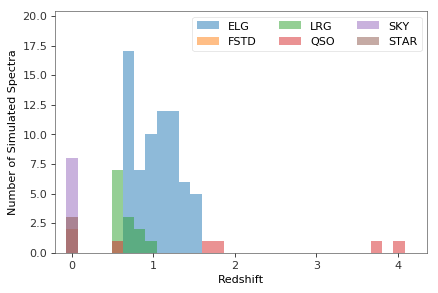

In [16]:
allobjtype = meta['OBJTYPE']
redlim = (-0.2, 1.1*meta['REDSHIFT'].max())
fig, ax = plt.subplots()
for objtype in sorted(set(allobjtype)):
    indx = objtype == allobjtype
    hh = ax.hist(meta['REDSHIFT'][indx], bins=nspec//3, 
                 label=objtype, alpha=0.5, range=redlim)
ax.set_xlabel('Redshift')
ax.set_ylabel('Number of Simulated Spectra')
ax.legend(loc='upper right', ncol=3)
ax.margins(0.2)
ax.set_xlim(redlim)

## Simulating spectra using quickgen.

We're now ready to simulate DESI spectra using `quickgen`!  Since we're calling `quickgen` from within this notebook (rather than from the command line in a terminal) we have to parse the `simspec` and `fibermap` filename inputs first.

`quickgen` generates four types of files and writes them to the *\$DESI_SPECTRO_REDUX/\$SPECPROD/exposures* directory: `calib`, `sky`, `cframe`, and `frame` files.  We will use the `cframe`, or calibrated frame files, which contain the flux-calibrated and sky-subtracted DESI spectra (one file per *brz* camera and spectrograph).  

The data model and the other files and their contents are documented here:  
http://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/PRODNAME/exposures/NIGHT/EXPID/index.html

The code in the following cell calls the equivalent of the command line:
```
quickgen --simspec {simspecfile} --fibermap {fiberfile}
```

In [17]:
args = quickgen.parse(['--simspec', simspecfile])
quickgen.main(args)

INFO:quickgen.py:239:main: Reading fibermap file /data/desi/spectro/sim/example/20170615/fibermap-00000000.fits
DEBUG:simexp.py:517:get_source_types: elg 69 targets
DEBUG:simexp.py:517:get_source_types: lrg 13 targets
DEBUG:simexp.py:517:get_source_types: qso 8 targets
DEBUG:simexp.py:517:get_source_types: sky 8 targets
DEBUG:simexp.py:517:get_source_types: star 2 targets
INFO:quickgen.py:272:main: Initializing SpecSim with config desi
DEBUG:specsim.py:39:get_simulator: Creating new desi Simulator
INFO:quickgen.py:278:main: Reading input file /data/desi/spectro/sim/example/20170615/simspec-00000000.fits
INFO:quickgen.py:677:main: Writing files for channel:b, spectrograph:0, spectra:0 to 100
INFO:quickgen.py:704:main: Wrote file /data/desi/spectro/redux/example/exposures/20170615/00000000/frame-b0-00000000.fits
INFO:quickgen.py:722:main: Wrote file /data/desi/spectro/redux/example/exposures/20170615/00000000/cframe-b0-00000000.fits
INFO:quickgen.py:737:main: Wrote file /data/desi/spectr

INFO:quickgen.py:704:main: Wrote file /data/desi/spectro/redux/example/exposures/20170615/00000000/frame-r0-00000000.fits
INFO:quickgen.py:722:main: Wrote file /data/desi/spectro/redux/example/exposures/20170615/00000000/cframe-r0-00000000.fits
INFO:quickgen.py:737:main: Wrote file /data/desi/spectro/redux/example/exposures/20170615/00000000/sky-r0-00000000.fits
INFO:quickgen.py:758:main: Wrote file /data/desi/spectro/redux/example/exposures/20170615/00000000/calib-r0-00000000.fits
INFO:quickgen.py:677:main: Writing files for channel:z, spectrograph:0, spectra:0 to 100
INFO:quickgen.py:704:main: Wrote file /data/desi/spectro/redux/example/exposures/20170615/00000000/frame-z0-00000000.fits
INFO:quickgen.py:722:main: Wrote file /data/desi/spectro/redux/example/exposures/20170615/00000000/cframe-z0-00000000.fits
INFO:quickgen.py:737:main: Wrote file /data/desi/spectro/redux/example/exposures/20170615/00000000/sky-z0-00000000.fits
INFO:quickgen.py:758:main: Wrote file /data/desi/spectro/re

#### Inspect the output cframe files ####

Let's briefly look at one of the `cframe` files for the blue camera using `desispec.io.frame.read_frame`, which returns a `Frame` class with all the attributes you might want.

In [18]:
cframefile = desispec.io.findfile('cframe', night=night, expid=expid, camera='b0')
print('Reading {}'.format(cframefile))
cframe = desispec.io.frame.read_frame(cframefile)

Reading /data/desi/spectro/redux/example/exposures/20170615/00000000/cframe-b0-00000000.fits


In [19]:
dir(cframe)

['R',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'chi2pix',
 'fibermap',
 'fibers',
 'flux',
 'ivar',
 'mask',
 'meta',
 'nspec',
 'nwave',
 'resolution_data',
 'spectrograph',
 'vet',
 'wave']

Let's make a quick plot of the zeroth spectrum.

In [20]:
print(cframe.wave.shape, cframe.flux.shape)

(4760,) (100, 4760)


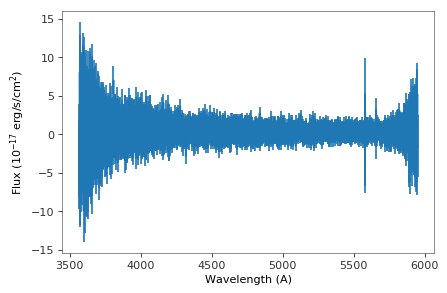

In [21]:
fig, ax = plt.subplots()
ax.errorbar(cframe.wave, cframe.flux[0, :], 1/np.sqrt(cframe.ivar[0, :]))
ax.set_xlabel('Wavelength (A)')
ax.set_ylabel('Flux ($10^{-17}$ erg/s/cm$^2$)')

## Regrouping the spectra ##

As you can imagine, working with `cframe` files is pretty tedious, especially across three cameras, 10 spectrographs, and more than 35 million targets!  Therefore, let's combine and reorganize the individual `cframe` files into `spectra` files grouped on the sky. Spectra are organized into healpix pixels (here chosen to have `nside=64`).  If you're interested, you can read more about the healpix directory structure here:  
https://github.com/desihub/desispec/blob/master/doc/nb/Intro_to_DESI_spectra.ipynb

Regrouping is especially important for real observations with overlapping tiles where the same object could be reobserved on different exposures separated by short or large amounts of time.

**TODO**: Add the *spectra* files to `desidatamodel`.

To regroup the spectra, we will run the (notebook) equivalent of the command:
```
desi_group_spectra --hpxnside 64
```

In [22]:
nside = 64
args = group_spectra.parse(['--hpxnside', '{}'.format(nside)])
group_spectra.main(args)

INFO:group_spectra.py:74:main: Starting at Tue Aug  1 16:51:41 2017
INFO:group_spectra.py:75:main:   using raw dir /data/desi/spectro/sim/example
INFO:group_spectra.py:76:main:   using spectro production dir /data/desi/spectro/redux/example
INFO:group_spectra.py:197:main: Distributing 4 spectral groups among 1 processes
INFO:group_spectra.py:220:main:   (0000) Begin spectral group spectra-64-12609 at Tue Aug  1 16:51:41 2017
INFO:group_spectra.py:294:main:   (0000) End spectral group spectra-64-12609 at Tue Aug  1 16:51:54 2017
INFO:group_spectra.py:220:main:   (0000) Begin spectral group spectra-64-12612 at Tue Aug  1 16:51:54 2017
INFO:group_spectra.py:294:main:   (0000) End spectral group spectra-64-12612 at Tue Aug  1 16:53:03 2017
INFO:group_spectra.py:220:main:   (0000) Begin spectral group spectra-64-19435 at Tue Aug  1 16:53:03 2017
INFO:group_spectra.py:294:main:   (0000) End spectral group spectra-64-19435 at Tue Aug  1 16:54:06 2017
INFO:group_spectra.py:220:main:   (0000) B

#### Inspect the output (combined and regrouped) spectra ####

So what did we end up with in the redux output directory?
* `exposures/{night}/{expid}/`: individual spectrograph camera spectra ("frames")
  grouped by night/expid
* `spectra-64/`: spectra grouped by healpix location on the sky

In [23]:
reduxdir = desispec.io.specprod_root()
!find $reduxdir | sort

/data/desi/spectro/redux/example
/data/desi/spectro/redux/example/exposures
/data/desi/spectro/redux/example/exposures/20170615
/data/desi/spectro/redux/example/exposures/20170615/00000000
/data/desi/spectro/redux/example/exposures/20170615/00000000/calib-b0-00000000.fits
/data/desi/spectro/redux/example/exposures/20170615/00000000/calib-r0-00000000.fits
/data/desi/spectro/redux/example/exposures/20170615/00000000/calib-z0-00000000.fits
/data/desi/spectro/redux/example/exposures/20170615/00000000/cframe-b0-00000000.fits
/data/desi/spectro/redux/example/exposures/20170615/00000000/cframe-r0-00000000.fits
/data/desi/spectro/redux/example/exposures/20170615/00000000/cframe-z0-00000000.fits
/data/desi/spectro/redux/example/exposures/20170615/00000000/frame-b0-00000000.fits
/data/desi/spectro/redux/example/exposures/20170615/00000000/frame-r0-00000000.fits
/data/desi/spectro/redux/example/exposures/20170615/00000000/frame-z0-00000000.fits
/data/desi/spectro/redux/example/exposures/20170615/

As a quick example, let's plot up the zeroth spectrum in healpix pixel `19435`.

In [24]:
specfilename = desispec.io.findfile('spectra', groupname=12637, nside=nside)

In [25]:
print('Reading {}'.format(specfilename))
specobj = desispec.io.read_spectra(specfilename)

Reading /data/desi/spectro/redux/example/spectra-64/126/12637/spectra-64-12637.fits


In [26]:
dir(specobj)

['R',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_bands',
 '_ftype',
 '_single',
 'bands',
 'extra',
 'fibermap',
 'flux',
 'ftype',
 'ivar',
 'mask',
 'meta',
 'num_spectra',
 'num_targets',
 'resolution_data',
 'select',
 'target_ids',
 'update',
 'wave',
 'wavelength_grid']

In [27]:
specobj.wave.keys(), specobj.flux.keys()

(dict_keys(['z', 'r', 'b']), dict_keys(['z', 'r', 'b']))

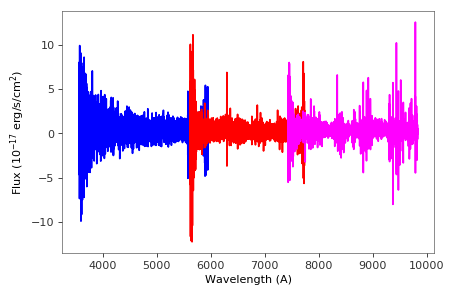

In [28]:
thisone = 0
fig, ax = plt.subplots()
for camera, color in zip( ('b', 'r', 'z'), ('blue', 'red', 'magenta') ):
    ax.plot(specobj.wave[camera], specobj.flux[camera][thisone], color=color)
ax.set_xlabel('Wavelength (A)')
ax.set_ylabel('Flux ($10^{-17}$ erg/s/cm$^2$)')